In [1]:
%pylab inline

import bilby
import lal
import lalsimulation as ls
from pycbc.waveform.generator import TDomainMassSpinRingdownGenerator, FDomainMassSpinRingdownGenerator
from src import waveforms as wf
from scipy import fftpack
from imp import reload
from astropy import units as u, constants as c
from scipy.optimize import brentq

Populating the interactive namespace from numpy and matplotlib


In [2]:
def add_default_units(quant,unit):
    if type(quant) == u.quantity.Quantity:
        return quant
    else:
        return quant*unit

In [3]:
def hp_hx_ringdown_lal(mfinal,afinal,mfrac,dist,l=2,m=2,
                       incl=0,azim=0,delta_T=1/4096,T_max=0.1):

    mfinal = add_default_units(mfinal,u.solMass)
    dist = add_default_units(dist,u.Mpc)

    ## God knows why LAL uses SI, but whatevs
    mfinal = mfinal.to(u.kg).value
    dist = dist.to(u.m).value
    
    epoch = lal.LIGOTimeGPS()
    hplus_lal, hcross_lal = ls.SimBlackHoleRingdown(
        epoch,azim,delta_T,mfinal,afinal,mfrac,dist,incl,l,m)

    times_lal = np.array([i*hplus_lal.deltaT for i in range(hplus_lal.data.length)])
    return hplus_lal.data.data, hcross_lal.data.data, times_lal

In [4]:
def hp_hx_ringdown_pycbc(mfinal,afinal,mfrac,dist,l=2,m=2,
                       incl=0,azim=0,delta_T=1/4096,T_max=0.1):

    generator = TDomainMassSpinRingdownGenerator(variable_args=['final_mass',
                    'final_spin','amp220','phi220'], lmns=['201'],
                    delta_t=delta_T, t_lower=0., t_final=T_max)
    
    hplus, hcross = generator.generate(final_mass=mfinal, final_spin=afinal,inclination=incl,
                           amp220=5e-21, amp200=1./10, phi220=40, phi200=0.)

    times = np.array([i*hplus.delta_t for i in range(hplus.data.size)])
    
    return np.array(hplus.data.data), np.array(hcross.data.data), times

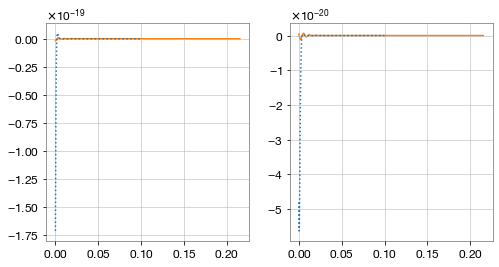

In [36]:
reload(wf)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

mf, af, dist, mfrac = 100, 0.69, 400, 0.01
incl, azim = 0.5, 0.3
l, m = 2,1
delta_T, T_max = 1./4096, 0.1

hp,hx,times = wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim,delta_T=delta_T,T_max=T_max,n=4,l=l,m=m)

ax1.plot(times,-4*pi*hp,zorder=10,ls=':')
ax2.plot(times,-4*pi*hx,zorder=10,ls=":")

hp,hx,times = hp_hx_ringdown_lal(mfinal=mf,afinal=af,mfrac=mfrac,dist=dist,l=l,m=m,
                       incl=incl,azim=azim,delta_T=delta_T,T_max=T_max)

ax1.plot(times,-hp)
ax2.plot(times,-hx)

# hp,hx,times = hp_hx_ringdown_pycbc(mfinal=mf,afinal=af,mfrac=mfrac,dist=dist,l=l,m=m,
#                        incl=incl,azim=azim,delta_T=delta_T,T_max=T_max)

# plot(times,hp*5)



In [198]:
reload(wf)

mf, af, dist, mfrac = 40, 0.69, 400, 0.01
incl = 1.3
l, m = 2,2
delta_T, T_max = 1./8192/64, 0.5

find_phi_hp = lambda phi: wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[0][0]
azim_p = brentq(find_phi_hp,0,np.pi/m)

find_phi_hx = lambda phi: wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=phi,delta_T=delta_T,T_max=T_max,l=l,m=m)[1][0]
azim_x = brentq(find_phi_hx,0,np.pi/m)

/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


(8.994531849295652e-06,
 3.98639425314254e-19,
 8.994531849295652e-06,
 -2.3090095975581083e-07)

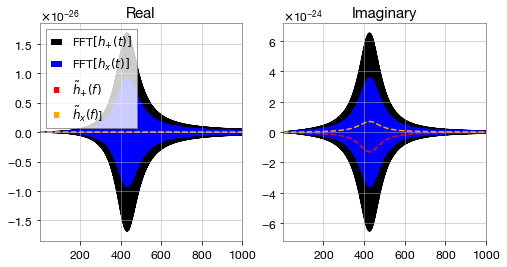

In [235]:
reload(wf)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

hp,_,times = wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_p,delta_T=delta_T,T_max=T_max,l=l,m=m)
_,hx,times = wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_x,delta_T=delta_T,T_max=T_max,l=l,m=m)

hp = hstack([-hp[:1:-1],hp])
hx = hstack([-hx[:1:-1],hx])

times = hstack([-times[:1:-1],times]) + times[-1]

num_samples = len(times)

delta_T = abs(times[1] - times[0])
hp_f = fftpack.fft(hp)
hx_f = fftpack.fft(hx)

freqs = linspace(0., 1/(2*delta_T),int(num_samples/2))
ax1.plot(freqs,2/num_samples * (hp_f[:num_samples//2]).real,color='black')
ax1.plot(freqs,2/num_samples * (hx_f[:num_samples//2]).real,color='blue')

ax2.plot(freqs,2/num_samples * (hp_f[:num_samples//2]).imag,color='black')
ax2.plot(freqs,2/num_samples * (hx_f[:num_samples//2]).imag,color='blue')

hplus_tilda,_ = wf.hp_hx_ringdown_single_mode(mf,af,mfrac,incl,dist,
                                                    phi0=azim_p,freqs=freqs,l=l,m=m)
_,hcross_tilda = wf.hp_hx_ringdown_single_mode(mf,af,mfrac,incl,dist,
                                                     phi0=azim_x,freqs=freqs,l=l,m=m)

# amp_ratio_p = (max((hplus_tilda).real)/max(2/num_samples * (hp_f[:num_samples//2]).real))
# amp_ratio_x = (max((hcross_tilda).real)/max(2/num_samples * (hx_f[:num_samples//2]).real))
ax1.plot(freqs,(hplus_tilda).real,color='r',linestyle='--')
ax1.plot(freqs,(hcross_tilda).real,color='orange',linestyle='--')

# amp_ratio_p = (max((hplus_tilda).imag)/max(2/num_samples * (hp_f[:num_samples//2]).imag))
# amp_ratio_x = (max((hcross_tilda).imag)/max(2/num_samples * (hx_f[:num_samples//2]).imag))
ax2.plot(freqs,(hplus_tilda).imag,color='r',linestyle='--')
ax2.plot(freqs,(hcross_tilda).imag,color='orange',linestyle='--')

ax1.set_xlim(1,1000)
ax2.set_xlim(1,1000)

ax1.legend((r"FFT$[h_{+}(t)]$",r"FFT$[h_x(t)]$",r"$\tilde{h}_{+}(f)$",r"$\tilde{h}_x(f)$]"))

ax1.set_title("Real",fontsize=15)
ax2.set_title("Imaginary",fontsize=15)

ratio1,ratio2,ratio3,ratio4 = (median(hp_f.real/hp_f.imag),
                               median(hplus_tilda.real/hplus_tilda.imag),
                               median(hp_f.real/hp_f.imag),
                               max(hplus_tilda.imag)/max(hcross_tilda.imag))

ratio1,ratio2,ratio3,ratio4

(0.0, 2000.0)

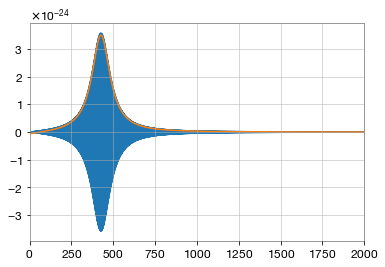

In [239]:
plot(2/num_samples *(hx_f).imag)

plot((hcross_tilda).imag*5)
xlim(0,2000)

/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Users/carl/opt/anaconda3/envs/bilby/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


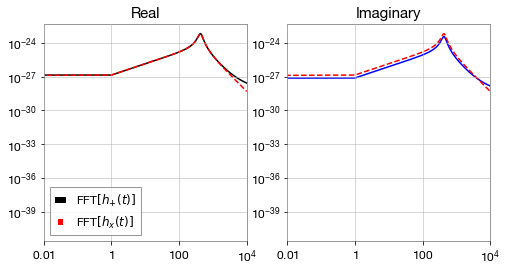

In [241]:
reload(wf)

subplots(1,2,figsize=(8,4))
ax1 = subplot(121)
ax2 = subplot(122)

hp,_,times = wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_p,delta_T=delta_T,T_max=T_max,l=l,m=m)
_,hx,times = wf.hp_hx_ringdown_time_domain(
    mf, af, mfrac,inclination=incl,dist=dist,phi0=azim_x,delta_T=delta_T,T_max=T_max,l=l,m=m)

hp = hstack([-hp[:1:-1],hp])
hx = hstack([-hx[:1:-1],hx])

times = hstack([-times[:1:-1],times]) + times[-1]

num_samples = len(times)

delta_T = abs(times[1] - times[0])
hp_f = fftpack.fft(hp)
hx_f = fftpack.fft(hx)

freqs = linspace(0., 1/(2*delta_T),int(num_samples/2))
ax1.plot(freqs,2/num_samples * np.abs(hp_f[:num_samples//2]),color='black')
ax2.plot(freqs,2/num_samples * np.abs(hx_f[:num_samples//2]),color='blue')

hplus_tilda,_ = wf.hp_hx_ringdown_single_mode(mf,af,mfrac,incl,dist,
                                                    phi0=azim_p,freqs=freqs,l=l,m=m)
_,hcross_tilda = wf.hp_hx_ringdown_single_mode(mf,af,mfrac,incl,dist,
                                                     phi0=azim_p,freqs=freqs,l=l,m=m)


amp_ratio_p = (max(np.abs(hplus_tilda))/max(2/num_samples * np.abs(hp_f[:num_samples//2])))
amp_ratio_x = (max(np.abs(hcross_tilda))/max(2/num_samples * np.abs(hx_f[:num_samples//2])))
ax1.plot(freqs,np.abs(hplus_tilda)/amp_ratio_p,color='r',linestyle='--')
ax2.plot(freqs,np.abs(hplus_tilda)/amp_ratio_p,color='r',linestyle='--')

ax1.set_xlim(0.01,10000)
ax2.set_xlim(0.01,10000)

ax1.legend((r"FFT$[h_{+}(t)]$",r"FFT$[h_x(t)]$",r"$\tilde{h}_{+}(f)$",r"$\tilde{h}_x(f)$]"))

ax1.set_title("Real",fontsize=15)
ax2.set_title("Imaginary",fontsize=15)

ratio1,ratio2,ratio3,ratio4 = (median(hp_f.real/hp_f.imag),
                               median(hplus_tilda.real/hplus_tilda.imag),
                               median(hp_f.real/hp_f.imag),
                               max(hplus_tilda.imag)/max(hcross_tilda.imag))

ratio1,ratio2,ratio3,ratio4

ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.set_yscale('log')
ax2.set_xscale('log')


In [33]:
amp_ratio_p

0.035007418838090124